In [163]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.io import imread_collection
from skimage.color import rgb2gray, gray2rgb
from skimage.exposure import histogram
from skimage.segmentation import slic, watershed, mark_boundaries
from skimage.filters import sobel
from scipy import ndimage as ndi
from scipy.io import loadmat

For this project, I've chosen 4 sample images from the Berkeley Segmentation Dataset, along with their ground truth labels in order to evaluate the segmentation. I chose only 4 images in order to manually optimize the parameters of each method for every image, and get the best results possible.<br>
The following code loads, arranges and plots the images and the labels

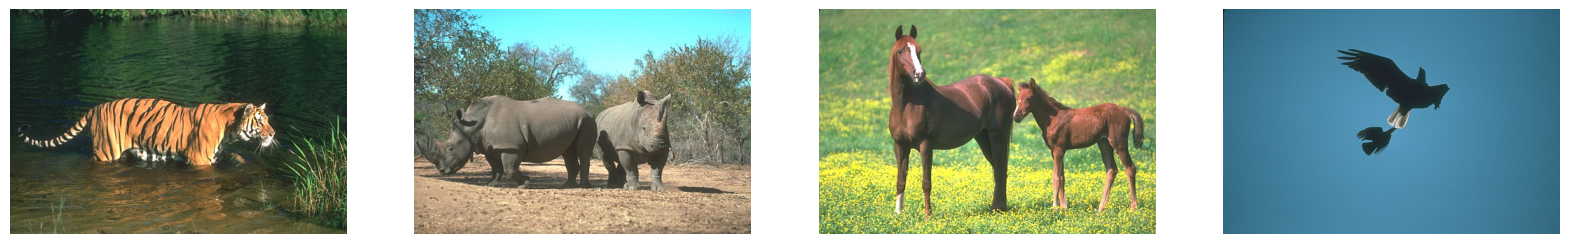

In [430]:
dir_name_imgs = "C:/Users/User/Documents/Image_processing/*.jpg"

images = imread_collection(dir_name_imgs)
image_names = [ 'tiger', 'rhinos', 'horses', 'eagle']
images_dict = {name : img for name, img in zip(image_names, images)}



fig, ax = plt.subplots(1,4, figsize = (20,20))
ax = ax.flatten()

for i , img in enumerate(images_dict.values()):
    ax[i].imshow(img)
    ax[i].axis('off')

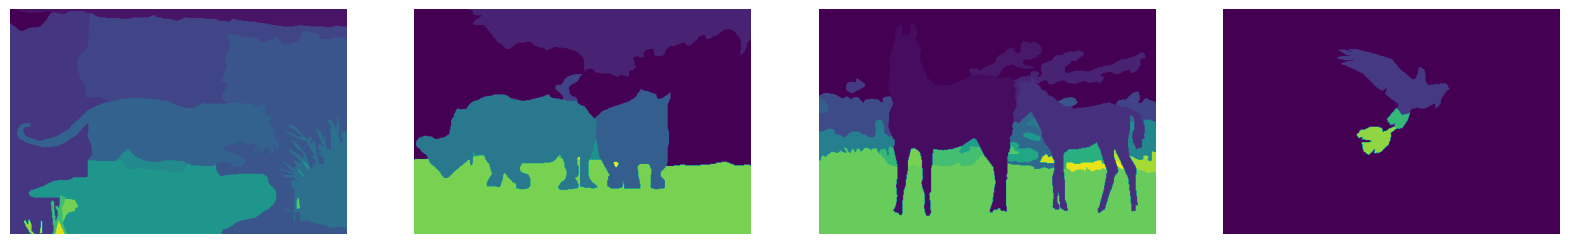

In [431]:
file_names = imread_collection("C:/Users/User/Documents/Image_processing/*.mat")
ground_truth_dict = {} 
for name, file in zip(image_names, file_names.files):
    mat = loadmat(file)
    truth = mat['groundTruth'][0][1][0][0][0]
    ground_truth_dict[name] = truth
    
fig, ax = plt.subplots(1,4, figsize = (20,20))
ax = ax.flatten()

for i , img in enumerate(ground_truth_dict.values()):
    ax[i].imshow(img)
    ax[i].axis('off')

For the sake of simplicity, in this exercise, we'll perform a binary segmentation. <br>
This choise was made because the metric we'll use to evaluate the performance (Dice, IoU, etc..) are inherently binary. 
They can be used on multiclass segmentation but the implemetation is complicated because the predicted labels don't necessarily match the ground truth labels.<br>
For this reason, we'll manually fix the ground truth labels to only include the object of interest in each image. 

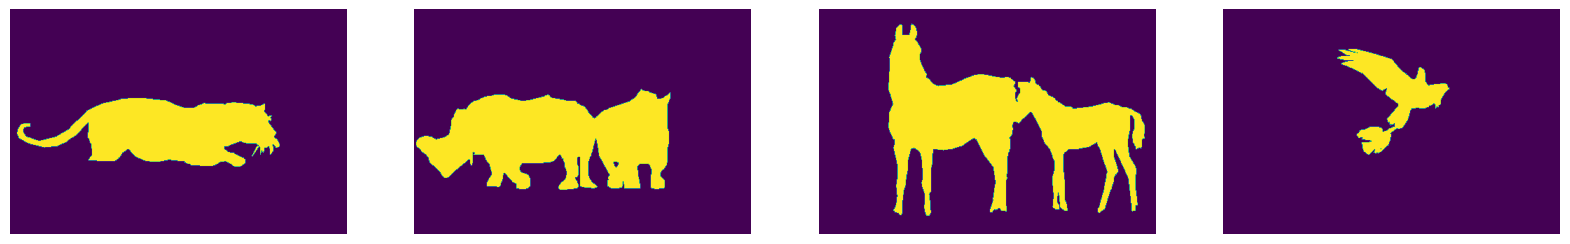

In [432]:
tiger_truth = ground_truth_dict['tiger']
binary_tiger_truth = np.zeros_like(tiger_truth)
binary_tiger_truth[tiger_truth == 7] = 1

rihno_truth = ground_truth_dict['rhinos']
binary_rihno_truth = np.zeros_like(rihno_truth)
binary_rihno_truth[rihno_truth == 4] = 1
binary_rihno_truth[rihno_truth == 5] = 1

horses_truth = ground_truth_dict['horses']
binary_horses_truth = np.zeros_like(horses_truth)
binary_horses_truth[horses_truth == 2] = 1
binary_horses_truth[horses_truth == 5] = 1

eagle_truth = ground_truth_dict['eagle']
binary_eagle_truth = np.zeros_like(eagle_truth)
binary_eagle_truth[eagle_truth == 2] = 1
binary_eagle_truth[eagle_truth == 6] = 1
binary_eagle_truth[eagle_truth == 5] = 1

ground_truth_dict.update({'tiger':binary_tiger_truth, 'rhinos': binary_rihno_truth, 'horses': binary_horses_truth, 'eagle': binary_eagle_truth})

fig, ax = plt.subplots(1,4, figsize = (20,10))

for i, img in enumerate(ground_truth_dict.values()):
    ax[i].imshow(img)
    ax[i].axis('off')


## the medthods we'll use to segment the images are:
1) Thresholding
2) K-means clustering
3) Watershed algorithm - a region based method

# Thresholding method

This is the most basic method. the idea is to convert the image to a one channel grayscale image, choose a threshold value and set each pixel below the threshold to 0 and each pixe above to 1. The result is a binary image divided to two segments.<br>It is possible to create a multiclass segmentation but for the sake of simplicity, we'll perform a binary segmentation.
The way to choose the threshold is by obseving the image histogram (and also trial and error..)<br> 
The atvantage of thresholding it's simplicity, as it is very easy and efficient. Sometimes, the simplest solution is the best one.<br>
The disadvantag is also it's simplicity. It's a very crude method that performs well only one very simple segmentation tasks, where the objects are very distinct brightness-wise. <br>
This method can be performed together with other methods, using thresholding to filter out noise and then using another method for more detailed segmentation.<br>
* note: in some images, the object is darker than the background so in order to lable it as 1 we'll need to take the negative of the binary image. 


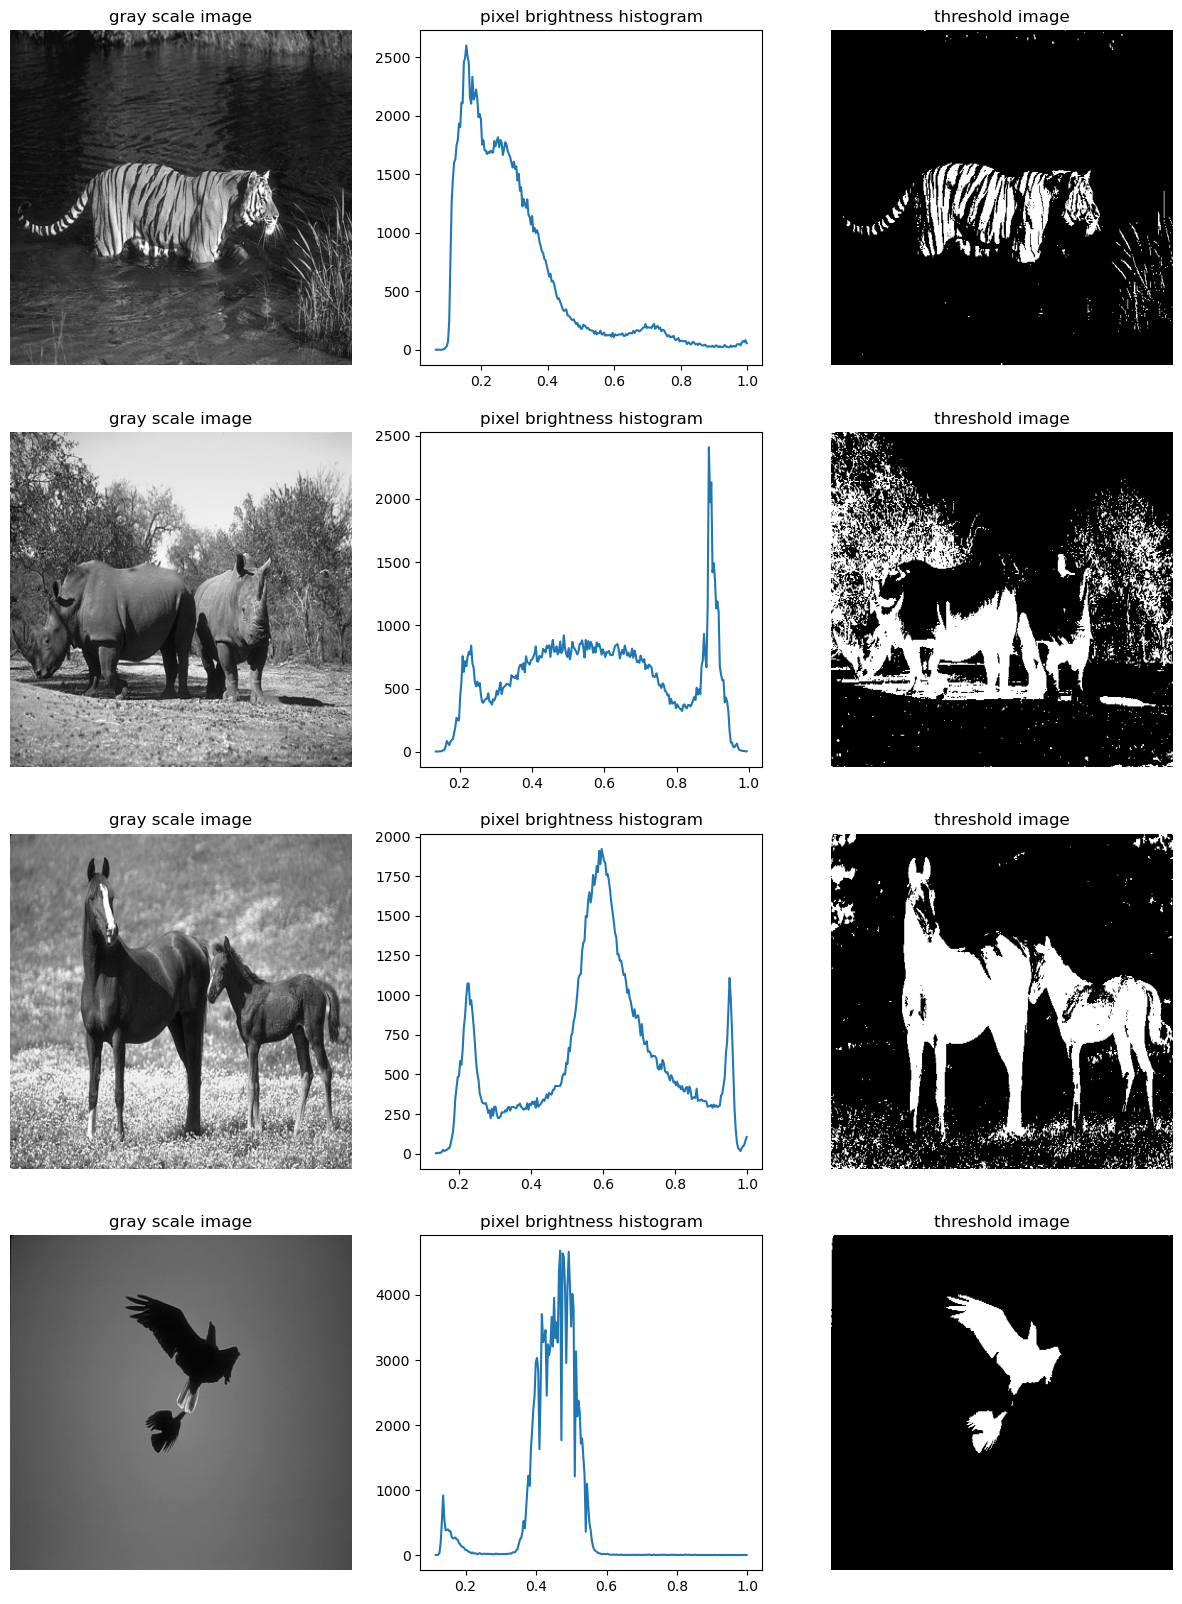

In [592]:
fig, ax = plt.subplots(4,3, figsize = (15,20))

thresholds = [0.6, 0.4, 0.5, 0.3] # manually selected thresholds
threshold_pred = []

for i, img in enumerate(images_dict.values()):
    
    gray_img = rgb2gray(img) # convert image to grayscale
    freq, value = histogram(gray_img) # calculate histogram
    thresh = gray_img > thresholds[i] # apply threshold
    
    if i > 0:
        thresh = thresh*-1 + 1 # take the negative of the binary image
    threshold_pred.append(thresh)
    
    # plot images
    ax[i][0].imshow(gray_img, cmap = 'gray', aspect = 'auto')
    ax[i][0].set_title('gray scale image')
    ax[i][0].axis('off')
    ax[i][1].plot(value, freq)
    ax[i][1].set_title('pixel brightness histogram')
    ax[i][2].imshow(thresh, cmap = 'gray', aspect = 'auto')
    ax[i][2].set_title('threshold image')
    ax[i][2].axis('off')

plt.show()

## K-means clustering

This method consisted of applying the K-means clustering algorithm in 5D space (r,g,b,x,y), where we combine the color (r,g,b) of each pixel with it's spacial coordinates (x,y). <br>
K-means is an iterative algorithm that repetedly performs two steps:
1) update the centroids of each cluster by calculating the mean of all point belonging to the cluster.
2) associate each point to it's closest centroid. <br> <br>

* note: the skimage library uses the SLIC algorithm, a variante of K-means which limits the search to smaller area an is thus more efficient. <br> 

The advansges of K-means include it's simplicity as well as guaranteed convergence. <br>
It's disadvansges include being dependent on initial values and sensitivity to outliers.
This method can be used for any segmentation task, for example, identifing organs in CT images.

 

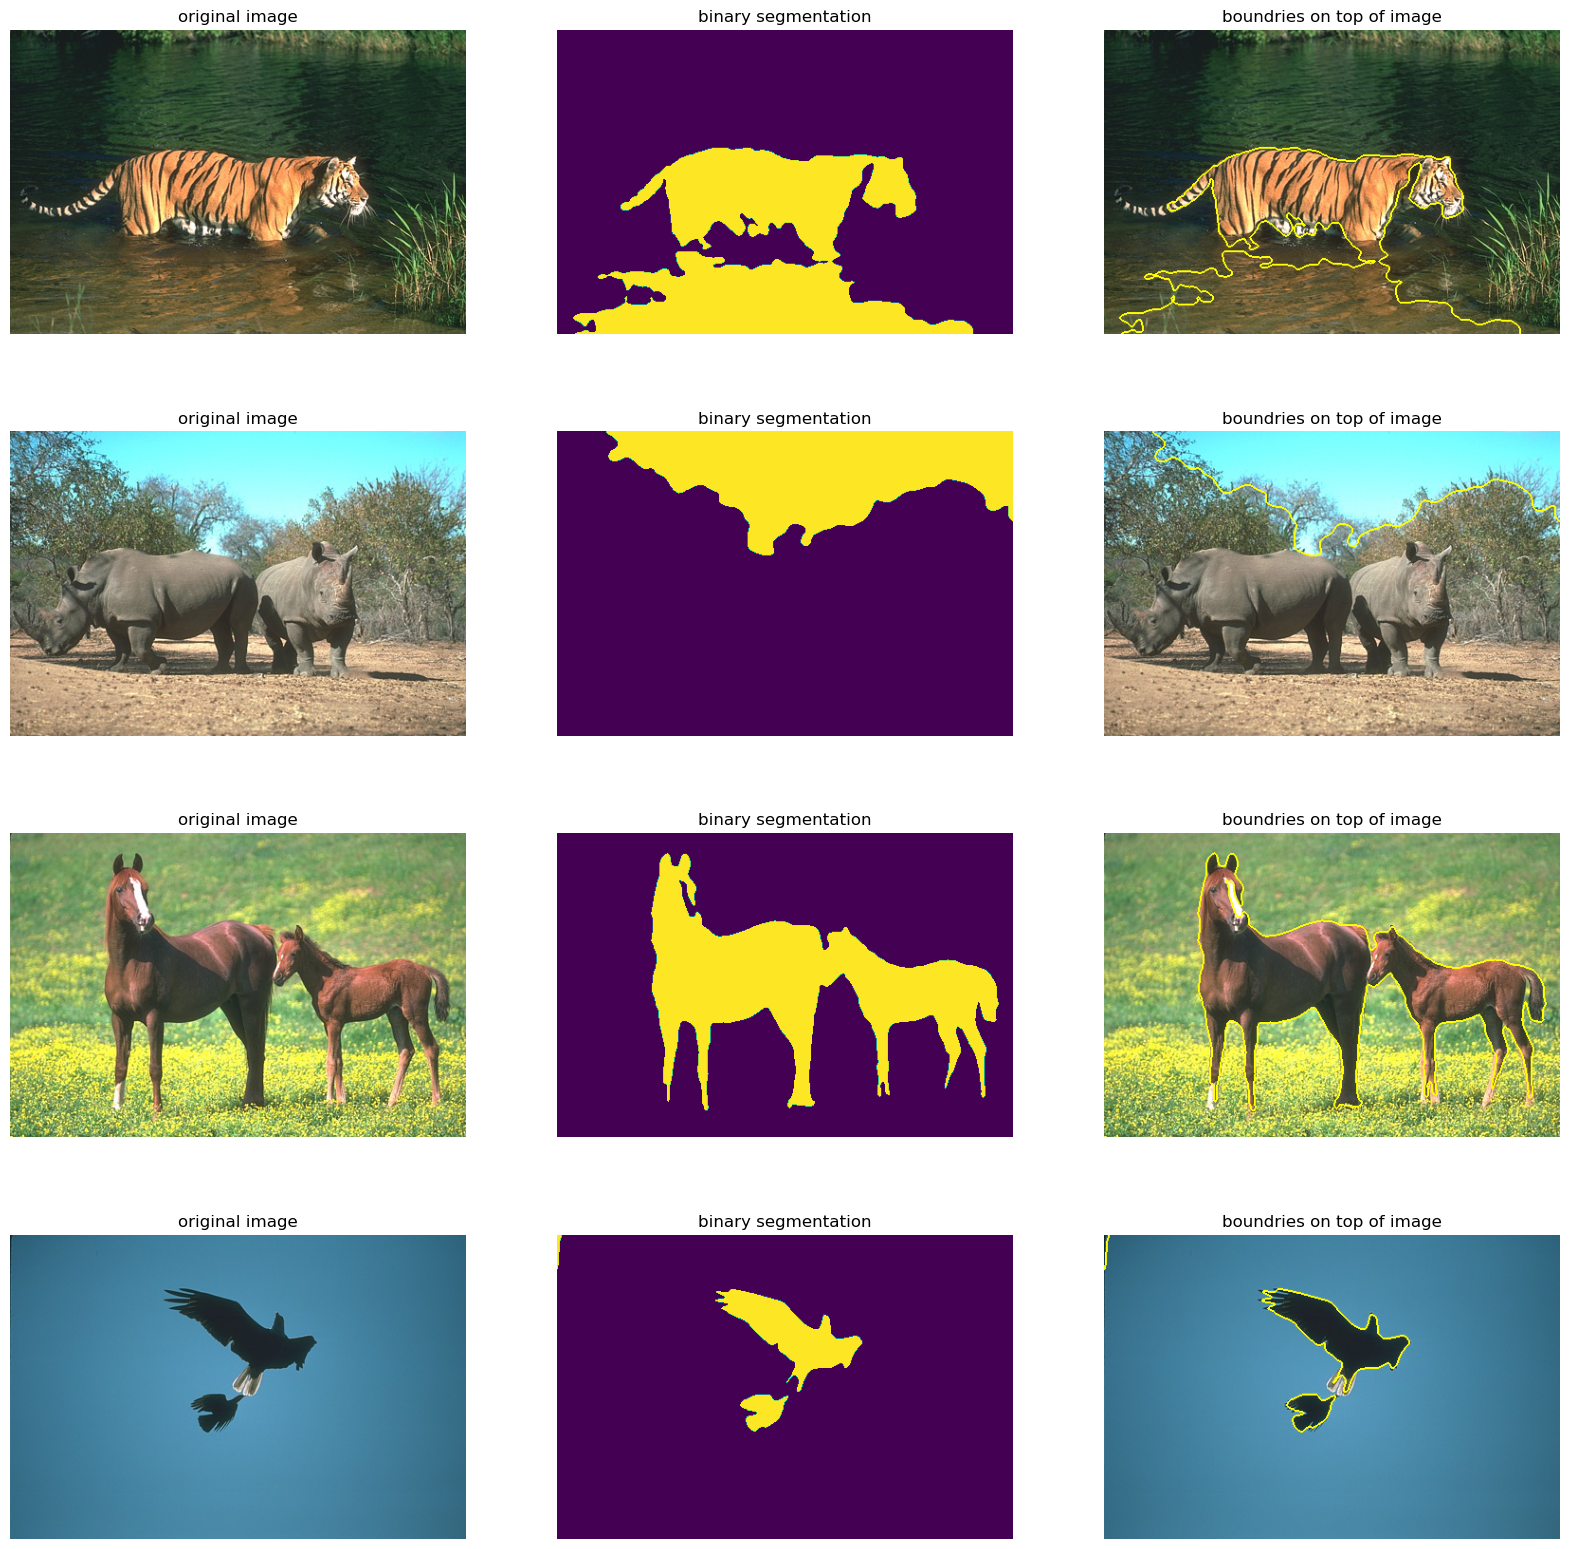

In [515]:

# manually selected parameters

# this parameter defines the balance between color and spacial proximity. higher values give more weight to space proximity   
comp = [10,5,4,5] 
# this is the sclale of the gaussian filter applyed before clustering
sig = [3,5,2,2] 

min_size = [0.1,0.1,0.1,0.5]
max_size = [5,5,5,0.8]
connectivity = [True, True, True, False]

slic_images = []

fig, ax = plt.subplots(4,3, figsize = (20,20))
for i, img in enumerate(images_dict.values()):

    slic_img = slic(img, n_segments=2, compactness=comp[i],sigma = sig[i], enforce_connectivity=connectivity[i], min_size_factor=min_size[i], max_size_factor=max_size[i])
    boundries = mark_boundaries(img, slic_img)
    slic_images.append(slic_img - 1)
    ax[i][0].imshow(img)
    ax[i][0].set_title('original image')
    ax[i][1].imshow(slic_img)
    ax[i][1].set_title('binary segmentation')
    ax[i][2].imshow(boundries)
    ax[i][2].set_title('boundries on top of image')
   
    for j in range(3):
        ax[i][j].axis('off')
    
    
plt.show()


## Watershed algorithm
the Watershed algorithm is a region based method. the idea is to 'flood' the image with 'water' starting from specific points until the landscape filles, creating a segmented image.
### Steps of the Watershed Algorithm <br>
1) Gradient Computation: Compute the gradient magnitude of the image. The gradient image highlights the edges of objects where the intensity changes rapidly, which corresponds to the steepest slopes in the topographic analogy.<br><br>

2) Marker Initialization: Identify markers (seeds) that belong to the regions of interest. Markers can be chosen manually or automatically. These markers are often placed in the regions that are sure to be inside the objects (foreground markers) and the regions that are sure to be outside the objects (background markers).<br><br>

3) Region Growing: Treat the image as a landscape being flooded by water starting from the markers. Water starts to fill the basins from the markers, and the algorithm simulates the flooding process:

* Water spreads from the markers outwards, merging areas with similar intensities.
* As the water from different markers meets, watershed lines (boundaries) are formed to prevent merging of distinct regions.
4) Formation of Watershed Lines: The locations where water from different markers meet are the watershed lines, which represent the boundaries between different segments in the image.

The advantages of using the watershed algorithm in image segmentation include its ability to induce closed object boundaries and its relatively low computation time compared to other segmentation methods.<br>
One major drawback is its tendency to result in over-segmentation, which can lead to inaccurate segmentation results.

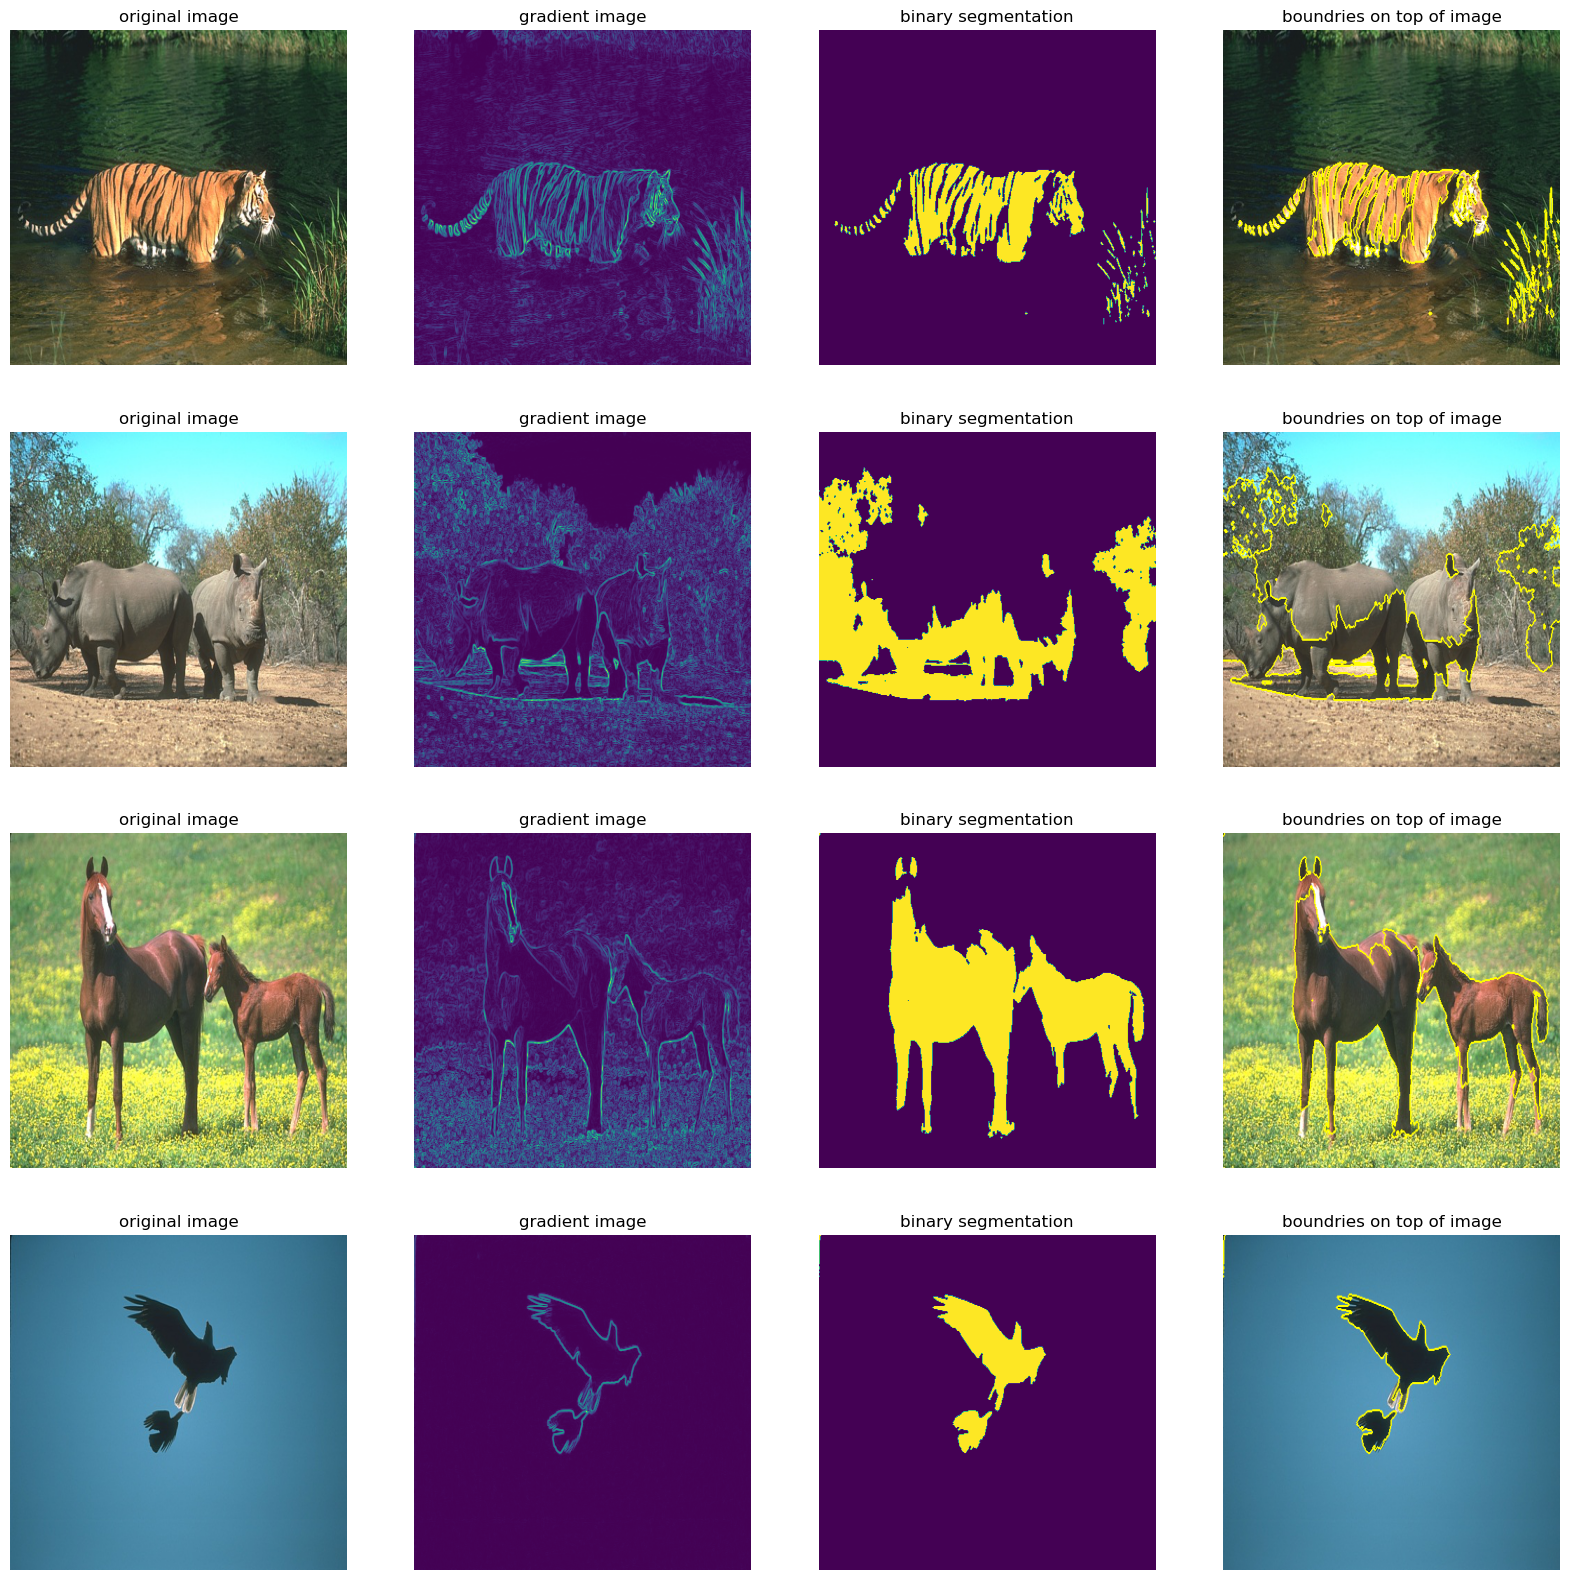

In [522]:
fig, ax = plt.subplots(4,4, figsize = (20,20))

water_images = []

for i, img in enumerate(images_dict.values()):
    
    img_gray = rgb2gray(img) # convert to gray scale
    elevation_map = sobel(img_gray) # calculate gradients
    markers = np.zeros_like(img_gray) # difine the markers. one label for low values and one for high values
    markers[img_gray < 0.2] = 1
    markers[img_gray > 0.7] = 2
    water_img = watershed(elevation_map, markers) 
    boundries = mark_boundaries(img, water_img)
    water_img -= 1 # correct image to 0 and 1
    
    if i > 0:
        water_img = water_img*-1 + 1
    water_images.append(water_img)
    ax[i][0].imshow(img, aspect= 'auto')
    ax[i][0].set_title('original image')
    ax[i][1].imshow(elevation_map, aspect= 'auto')
    ax[i][1].set_title('gradient image')
    ax[i][2].imshow(water_img, aspect= 'auto')
    ax[i][2].set_title('binary segmentation')
    ax[i][3].imshow(boundries, aspect= 'auto')
    ax[i][3].set_title('original image')
    ax[i][3].set_title('boundries on top of image')
    for j in range(4):
        ax[i][j].axis('off')


plt.show()



# Evaluation

In [570]:
from sklearn.metrics import recall_score, precision_score, f1_score
import pandas as pd


# code for evaluating the performance of each methods using precision, recall, f1 score, dice coefficient and IoU metrics 


def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3)

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def evaluate(groundtruths, preds):
    res = {}
    for (name, truth), pred in zip(groundtruths.items(), preds):
        precicion = precision_score(truth, pred,  average='micro')
        recall = recall_score(truth, pred,  average='micro')
        f1 = f1_score(truth, pred,  average='micro')
        dice = dice_coef(truth, pred)
        iou_ = iou(truth, pred)
        res[name] = [round(precicion,3), round(recall,3), round(f1,3), dice, iou_]
        
    index = ['precision', 'recall', 'f1 score', 'dice coefficient', 'IoU']
    res_df = pd.DataFrame(res, index = index)
    res_df = res_df.transpose()
    res_df.loc['average'] = round(res_df.mean(),3)
    return res_df
    

res_watershed = evaluate(ground_truth_dict, water_images)
res_slic = evaluate(ground_truth_dict, slic_images)
res_thresh = evaluate(ground_truth_dict, threshold_pred)


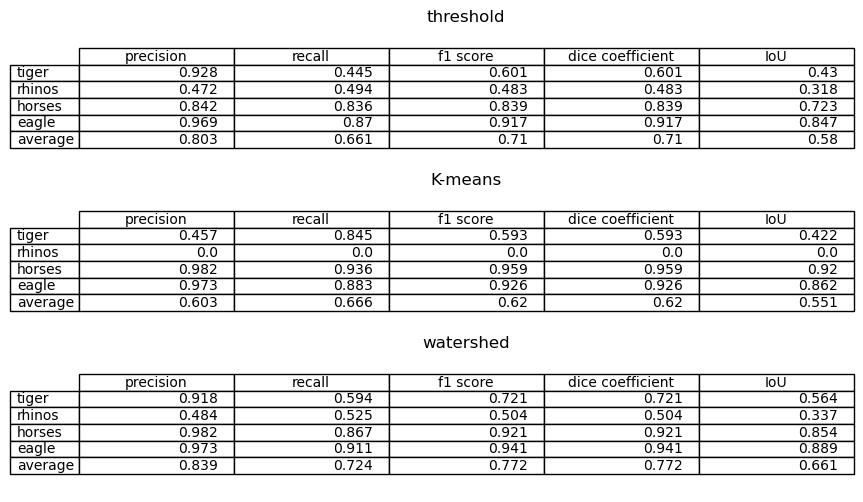

In [571]:
fig, ax = plt.subplots(3,1,figsize = (10,6))

# hide axes
# fig.patch.set_visible(False)
ax[0].axis('off')
ax[0].set_title('threshold')
ax[0].table(cellText=res_thresh.values, colLabels=res_thresh.columns, rowLabels=res_thresh.index, loc = 'center')

ax[1].axis('off')

ax[1].set_title('K-means')
ax[1].table(cellText=res_slic.values, colLabels=res_slic.columns, rowLabels=res_slic.index, loc = 'center')

ax[2].axis('off')
ax[2].set_title('watershed')
ax[2].table(cellText=res_watershed.values, colLabels=res_watershed.columns, rowLabels=res_watershed.index, loc = 'center')

# discussion

The threshold method worked pretty well on well difined images like the 'eagle' but extremly poorly on more difficult ones like the 'rhinos'.<br>

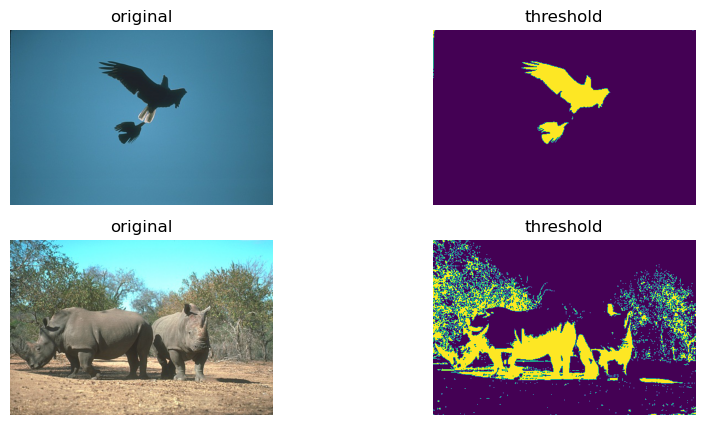

In [588]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax = ax.flatten()
ax[0].imshow(images_dict['eagle'])
ax[0].set_title('original')
ax[1].imshow(threshold_pred[2])
ax[1].set_title('threshold')
ax[2].imshow(images_dict['rhinos'])
ax[2].set_title('original')
ax[3].imshow(threshold_pred[1])
ax[3].set_title('threshold')
for i in range(4):
    ax[i].axis('off')

The K- means and Watershed methods worked better on all images. <br>
K-means performed better on the 'horses' image because it has a good contrast of colors and theis method take into account the colors. <br>
The Watershed considers the topology of the image. It performed better on the 'tiger', where the colors are more blured (like the reflection of the tiger in the water).



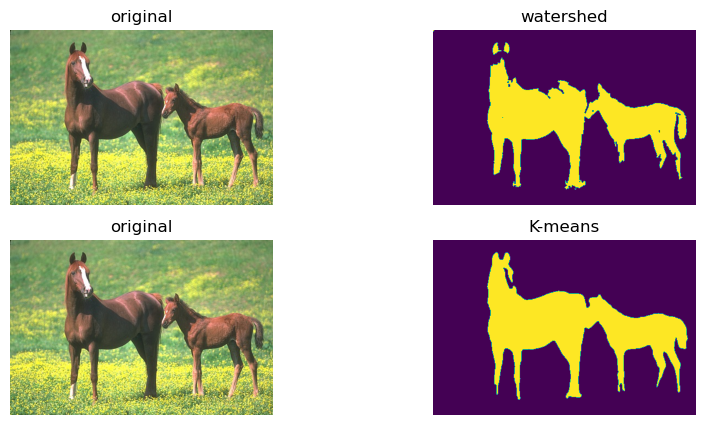

In [590]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax = ax.flatten()
ax[0].imshow(images_dict['horses'])
ax[0].set_title('original')
ax[1].imshow(water_images[2])
ax[1].set_title('watershed')
ax[2].imshow(images_dict['horses'])
ax[2].set_title('original')
ax[3].imshow(slic_images[2])
ax[3].set_title('K-means')
for i in range(4):
    ax[i].axis('off')

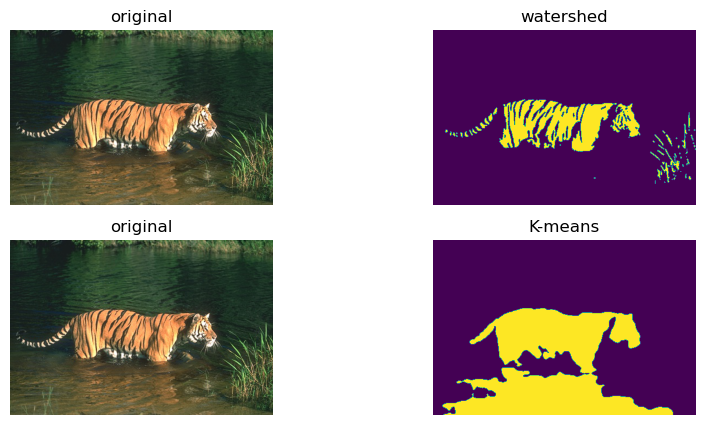

In [591]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax = ax.flatten()
ax[0].imshow(images_dict['tiger'])
ax[0].set_title('original')
ax[1].imshow(water_images[0])
ax[1].set_title('watershed')
ax[2].imshow(images_dict['tiger'])
ax[2].set_title('original')
ax[3].imshow(slic_images[0])
ax[3].set_title('K-means')
for i in range(4):
    ax[i].axis('off')

Overall the Watershed method performed the best out of all three, with K-means coming second. 
My hypothesis is that the Watershed algorithm is more robust and less sensitive to noise than K-means. Also, it does'nt depend on initial conditions.<br>
In conclusion, each method has it's strengths and weaknesses and the choise depends on the task at hand.
All methods require a lot of parameter tuning for every image in order to achieve the best results. This was the most chalenging part of implementing them.